In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from PIL import Image
import numpy as np
import random
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining Similarity Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PearsonCorrelationLoss(nn.Module):
    def _init_(self):
        super(PearsonCorrelationLoss, self)._init_()

    def forward(self, predicted, target):
        # Calculate the mean of predicted and target values
        predicted_mean = torch.mean(predicted)
        target_mean = torch.mean(target)

        # Calculate the covariance and variances
        covar = torch.mean((predicted - predicted_mean) * (target - target_mean))
        predicted_var = torch.mean((predicted - predicted_mean)**2)
        target_var = torch.mean((target - target_mean)**2)

        # Calculate the Pearson correlation coefficient
        pearson_corr = covar / (torch.sqrt(predicted_var) * torch.sqrt(target_var))

        # The loss is the negative of the correlation coefficient to be minimized
        loss = -pearson_corr

        return loss

pearson_correlation = PearsonCorrelationLoss()

class CustomSigmoid(nn.Module):
    def __init__(self):
        super(CustomSigmoid, self).__init__()

    def forward(self, x):
        # Implement the sigmoid function using the torch.sigmoid function
        sigmoid_x = torch.sigmoid(x)
        return sigmoid_x

# Example usage:
custom_sigmoid = CustomSigmoid()

class CustomCosineSimilarity(nn.Module):
    def __init__(self, eps=1e-8):
        super(CustomCosineSimilarity, self).__init__()
        self.eps = eps

    def forward(self, x1, x2):
        # Compute the cosine similarity between x1 and x2
        dot_product = torch.sum(x1 * x2, dim=-1)
        norm_x1 = torch.norm(x1, dim=-1, p=2) + self.eps
        norm_x2 = torch.norm(x2, dim=-1, p=2) + self.eps
        cosine_sim = dot_product / (norm_x1 * norm_x2)
        return cosine_sim

# Example usage:

custom_cosine_similarity = CustomCosineSimilarity()

# similarity = custom_cosine_similarity(x1, x2)




Tweaking the no. of shots

In [ ]:
shot=14

Preprocessing the data for suitable input shape

In [ ]:
import os
import itertools

def change_size(dataset_root, dataset_root_new):
    class_folders = os.listdir(dataset_root)
    for class_folder in class_folders:
        wherewe_have_to_add = os.path.join(dataset_root_new, class_folder)
        class_path = os.path.join(dataset_root, class_folder)
        os.makedirs(wherewe_have_to_add)
        image_files = os.listdir(class_path)
        for i in image_files:
            new_path = os.path.join(class_path, i);
            grayscale_image = Image.open(new_path)

            # Create a new RGB image with the desired size
            new_image = Image.new("RGB", (224, 224), "white")

            # Paste the grayscale image onto the RGB image's center
            x_offset = (224 - 105) // 2
            y_offset = (224 - 105) // 2
            new_image.paste(grayscale_image, (x_offset, y_offset))

            # Convert the image to a NumPy array
            rgb_image = np.array(new_image)

            # Create three channels by copying the single-channel data to all channels
            rgb_image = np.stack([rgb_image] * 3, axis=-1)

            # Save the modified RGB image to a specific directory with a new name
            new_image.save(os.path.join(wherewe_have_to_add, i))

            # Display the RGB image
            new_image.show()



def generate_test_representative(dataset_root, no_of_shot):
    images = []
    class_folders = os.listdir(dataset_root)
    #Test Data
    for class_ in class_folders:
      path_class = os.path.join(dataset_root,class_ )
      image_in_class = os.listdir(path_class)
      for image in image_in_class:
        images.append(os.path.join(path_class, image))
    #random.shuffle(images)

    #Representative data
    rep_data = []
    for class_ in class_folders:
      path_class = os.path.join(dataset_root,class_ )
      images_in_class = os.listdir(path_class)
      # print(images_in_class)
      random_values = random.sample(images_in_class, no_of_shot)
      # print(random_values)
      to_add = []
      for basename in random_values:
        to_add.append(os.path.join(path_class, basename))
      rep_data.append(to_add)
    return (images, rep_data)


dataset_root     = "/content/drive/My Drive/Greek"
dataset_root_new = "/content/drive/My Drive/Greek_new"




In [ ]:
(images, rep_data) = generate_test_representative(dataset_root_new, shot )
images_path = images
rep_data_path = rep_data


In [ ]:
import matplotlib.pyplot as plt

for i in range(0, len(images)):
      image  = Image.open(images[i])
      images[i] = transforms.ToTensor()(image)
      #imgplot = plt.imshow(img)
      images[i] = torch.tensor(images[i])
print(images[0].shape)

<ipython-input-40-38075824437d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images[i] = torch.tensor(images[i])


torch.Size([3, 224, 224])


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(0, len(rep_data)):
    for j in range(0,shot):
      image =Image.open(rep_data[i][j])
      #imgplot  = plt.imshow(img)
      rep_data[i][j]= transforms.ToTensor()(image)
print(rep_data[0][0].shape)


torch.Size([3, 224, 224])


Generating pretrained model

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset


def general_model(index, images,rep_images ):
  # Load the pre-trained ResNet model without additional layers


  # Extract the last layer (before classification)

  vgg16_model = models.vgg16(pretrained=True)

  # Extract the feature layers (excluding the classification layers)
  pretrained_features = nn.Sequential(*list(vgg16_model.features.children())[:-1])

  Final = []
  for image_sample in images:
    with torch.no_grad():
      image_tensor = image_sample.unsqueeze(0)  # Add a batch dimension
      # print(image_tensor.shape)
      features1 = vgg16_model(image_tensor)
    # features1 = resnet_model(image_sample)
    fin_output = []
    for class_ in rep_images:
      prob = []
      for image in class_:

        with torch.no_grad():
          image_tensor = image.unsqueeze(0)  # Add a batch dimension
          features2 = vgg16_model(image_tensor)

        similarity_index = index(features1, features2)
        prob.append(similarity_index)
      val = 0;
      for value in prob:
        val+=value

      fin_output.append(val/len(prob))
    ind = 0
    maxi = 0
    for i in range(len(fin_output)-1):
      if(fin_output[i] > maxi):
        maxi = max( maxi, fin_output[i])
        ind = i
    Final.append([ind, maxi])



  return Final
# You can use `features1` and `features2` for similarity calculation (e.g., cosine similarity) or any other task you have in mind.


In [ ]:
print(rep_data[0][0].shape)

torch.Size([3, 224, 224])


Running the model and achieving similiarity score

In [ ]:
a = general_model(custom_cosine_similarity,images[0:20], rep_data)
print(a)

[[12, tensor([0.7818])], [0, tensor([0.7887])], [0, tensor([0.7614])], [0, tensor([0.7411])], [19, tensor([0.7492])], [0, tensor([0.7572])], [0, tensor([0.7356])], [0, tensor([0.7841])], [19, tensor([0.7957])], [0, tensor([0.7864])], [19, tensor([0.7772])], [14, tensor([0.7007])], [0, tensor([0.7307])], [9, tensor([0.7745])], [19, tensor([0.7803])], [12, tensor([0.7691])], [5, tensor([0.7792])], [19, tensor([0.7694])], [9, tensor([0.7915])], [0, tensor([0.7796])]]


Plotting accuracy vs No. of shots

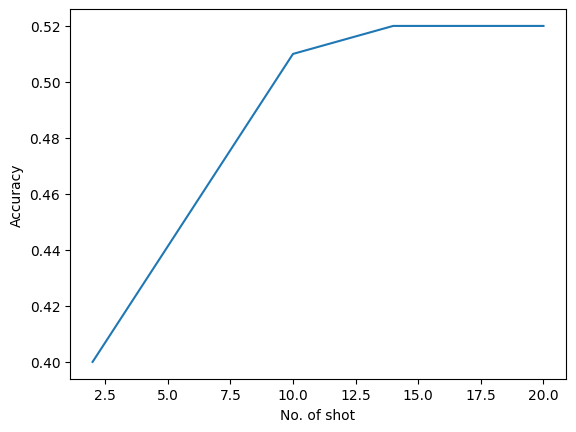